In [1]:
%%html
<style>
p {
    max-width: 45em;
    word-wrap: break-word;
    }
li{
    max-width: 40em;
    word-wrap: break-word;
    margin:0 0 5px 0;
    }
</style>

<br>
<br>
<p style="text-align:center; font-family: Arial; max-width: 65em">
<font size=6>Ecological Footprint and Human Development Index 2016</font>
<br>
<br>
<br></p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-extraction-and-preparation" data-toc-modified-id="Data-extraction-and-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data extraction and preparation</a></span><ul class="toc-item"><li><span><a href="#Import-data-through-the-GFN-API" data-toc-modified-id="Import-data-through-the-GFN-API-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import data through the GFN API</a></span></li><li><span><a href="#Import-list-of-independent-States-by-scraping-online-HTML-table" data-toc-modified-id="Import-list-of-independent-States-by-scraping-online-HTML-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Import list of independent States by scraping online HTML table</a></span></li><li><span><a href="#Import-list-of-countries-with-regions-from-GitHub-repository" data-toc-modified-id="Import-list-of-countries-with-regions-from-GitHub-repository-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Import list of countries with regions from GitHub repository</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Ecological-Footprint-by-continent" data-toc-modified-id="Ecological-Footprint-by-continent-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ecological Footprint by continent</a></span></li><li><span><a href="#Human-Development-Index-by-continent" data-toc-modified-id="Human-Development-Index-by-continent-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Human Development Index by continent</a></span></li><li><span><a href="#Ecological-Footprint-vs-Human-Development-Index" data-toc-modified-id="Ecological-Footprint-vs-Human-Development-Index-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ecological Footprint vs Human Development Index</a></span></li><li><span><a href="#Development-efficiency" data-toc-modified-id="Development-efficiency-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Development efficiency</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Introduction

The goal of this data analysis is to study the relationship between the ecological footprint (EF) and the Human Development Index (HDI) of countries worldwide using the latest data available which dates from 2016 (as of October 2020).

The EF measures the surface area needed to provide the resources necessary to meet consumer demand in any given country. This includes the surface area used for food crops, fiber production, timber regeneration, absorption of  carbon dioxide emissions from fossil fuel burning, and built infrastructure. Imports and exports are taken into account. Further details can be found [here](https://www.footprintnetwork.org/resources/data/). This indicator is provided by the *Global Footprint Network* (GFN), a non-profit organization whose mission is to help end ecological overshoot by making ecological limits central to decision-making.

The HDI measures the level of development of a country by combining indices that assess three key dimensions: health, education and standard of living. Health is assessed by life expectancy at birth, education is measured by mean of years of schooling for adults aged 25 years and more and expected years of schooling for children of school entering age. Standard of living is measured by gross national income per capita. Further details can be found [here](http://hdr.undp.org/en/content/human-development-index-hdi). The HDI is calculated by the *United Nations Development Programme* using data from various sources.

This notebook presents the entire data analysis process starting with the extraction of the raw data from online sources, followed by data preparation operations and finishing with a few descriptive graphs, the one of key interest being the scatterplot showing the relationship betweenship ecological footprint and the HDI for countries worldwide.

In [2]:
# Import packages and set package parameters
import os
import requests
from bs4 import BeautifulSoup
import json
import re
from math import sqrt, floor, ceil
import numpy as np
import pandas as pd
pd.set_option('precision',2) # Limit number of significant figures displayed in outputs
# pd.set_option('display.max_rows', None) # Display full pd.DataFrame
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6) # Set default figure size in inches (width, height)
import seaborn as sns
import altair as alt

# Data extraction and preparation

## Import data through the GFN API

The data concerning both the EF and the HDI can be accessed on the GFN website as an [excel file containing all the data](https://www.footprintnetwork.org/licenses/public-data-package-free/), as individual datasets through the [Ecological Footprint Explorer open data platform](https://data.footprintnetwork.org/#/exploreData) or through the [website's API](https://data.footprintnetwork.org/#/api) for which an API key must be requested using their *API Key Request Form* to be able to access the data. The data is provided by the GFN under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).
  
For this data analysis, the data will be imported through the API as it makes the whole process easier to reproduce and requires fewer files.

In [3]:
# Set API key and username needed for authentication to access the GFN API
import config # Script file containing confidential authentication details
api_key = config.api_key # API key received from the GFN by email
user_agent = config.user_agent # User name which can be any string

Different datasets can be accessed through the API, the *types* dataset lists all the indicators that are available.

In [4]:
# Extract list of available types of indicators and check that API
# access is successful
url = 'http://api.footprintnetwork.org/v1/types'
request_types = requests.get(url, auth=(user_agent, api_key))
request_types.status_code # Check that request is successful: HTTP code = 200

200

In [5]:
# Display json file contents listing available indicators
types_json = request_types.json()
df_types = pd.DataFrame(types_json)
df_types

,id,version,code,record,note,enabled,name
0,3,None,BCpc,BiocapPerCap,Biocapacity divided by population in global he...,1,Biocapacity per person
1,4,None,BCtot,BiocapTotGHA,Total biocapacity in global hectares (gha),1,Biocapacity
2,5,None,EFCpc,EFConsPerCap,Ecological Footprint of consumption in global ...,1,Ecological Footprint per person
3,6,None,EFCtot,EFConsTotGHA,Total Ecological Footprint of consumption in g...,1,Ecological Footprint
4,13,None,earth,BiocapTotGHA,EFConsPerCap of Country / EFConsPerCap of World,1,Earths
5,14,None,pop,Population,Population,1,Population
6,15,None,hdi,HDI,Human Development Index; Source: Trends in the...,1,Human Development Index
7,16,None,gdp,GDP,GDP per capita (constant 2010 US$); Source: Wo...,1,Gross Domestic Product


For this data analysis, these three variables will be extracted: *Earths, Population and Human Development Index*. *Earths* measures how many Earths would be required to provide the surface required to meet consumption needs if everyone on the planet were to consume at the same level as the given country.

The HDI can also be accessed through the [API of the United Nations Human Development Report Office](http://hdr.undp.org/en/content/human-development-report-office-statistical-data-api) where the data may be slightly more up to date as it is recalculated retroactively each year with the integration of new methodologies and updated data.

In [6]:
# Extract data on population, ecological footprint (in terms of number
# of Earths), and the Human Development Index
url = 'http://api.footprintnetwork.org/v1/data/all/2016/pop,earth,hdi'
request_ef2016 = requests.get(url, auth=(user_agent, api_key))
request_ef2016.status_code

200

In [7]:
df_ef2016_raw = pd.DataFrame(request_ef2016.json())
df_ef2016_raw

,id,version,year,countryCode,countryName,shortName,isoa2,record,cropLand,grazingLand,forestLand,fishingGround,builtupLand,carbon,value,score
0,155669,None,2016,1,Armenia,Armenia,AM,Earths,0.35,0.13,0.15,3.23e-03,0.04,0.51,1.19e+00,3A
1,117204,None,2016,1,Armenia,Armenia,AM,HDI,NaN,NaN,NaN,NaN,NaN,NaN,7.49e-01,None
2,121452,None,2016,1,Armenia,Armenia,AM,Population,NaN,NaN,NaN,NaN,NaN,NaN,2.92e+06,None
3,155725,None,2016,2,Afghanistan,Afghanistan,AF,Earths,0.19,0.11,0.04,1.16e-04,0.02,0.09,4.46e-01,3A
4,117219,None,2016,2,Afghanistan,Afghanistan,AF,HDI,NaN,NaN,NaN,NaN,NaN,NaN,4.94e-01,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,166183,None,2016,2005,Oceania,º Oceania,None,Earths,0.33,0.07,0.47,2.63e-01,0.05,2.02,3.20e+00,None
624,151624,None,2016,2005,Oceania,º Oceania,None,HDI,NaN,NaN,NaN,NaN,NaN,NaN,8.40e-01,None
625,166239,None,2016,5001,World,º World,None,Earths,0.33,0.09,0.17,5.51e-02,0.04,1.01,1.69e+00,3A
626,152638,None,2016,5001,World,º World,None,HDI,NaN,NaN,NaN,NaN,NaN,NaN,7.04e-01,None


The *record* column shows that the values of three variables of interest are contained on different lines of the *value* column. Country names and the ISO 3166-1 alpha-2 country codes are also needed for merging with other datasets later on.

In [8]:
# Select columns of interest
df_ef2016_select = df_ef2016_raw[['shortName', 'isoa2', 'record', 'value']]
df_ef2016_select

,shortName,isoa2,record,value
0,Armenia,AM,Earths,1.19e+00
1,Armenia,AM,HDI,7.49e-01
2,Armenia,AM,Population,2.92e+06
3,Afghanistan,AF,Earths,4.46e-01
4,Afghanistan,AF,HDI,4.94e-01
...,...,...,...,...
623,º Oceania,None,Earths,3.20e+00
624,º Oceania,None,HDI,8.40e-01
625,º World,None,Earths,1.69e+00
626,º World,None,HDI,7.04e-01


In [9]:
df_ef2016_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   shortName  628 non-null    object 
 1   isoa2      549 non-null    object 
 2   record     628 non-null    object 
 3   value      628 non-null    float64
dtypes: float64(1), object(3)
memory usage: 19.8+ KB


The *record* column needs to be split into separate columns containing the variables of interest and the columns can be renamed for better readability.

In [10]:
# Pivot table, reset index and rename columns
df_ef2016_pivot = df_ef2016_select.pivot_table(index=['shortName','isoa2'], columns=['record'], values='value').reset_index()
df_ef2016_pivot.columns = ['country', 'code', 'Earths', 'HDI', 'population']
df_ef2016_pivot

,country,code,Earths,HDI,population
0,Afghanistan,AF,0.45,0.49,3.47e+07
1,Albania,AL,1.23,0.78,2.93e+06
2,Algeria,DZ,1.48,0.75,4.06e+07
3,Angola,AO,0.62,0.58,2.88e+07
4,Antigua and Barbuda,AG,2.66,0.78,1.01e+05
...,...,...,...,...,...
182,Venezuela,VE,1.56,0.77,3.16e+07
183,Viet Nam,VN,1.30,0.69,9.46e+07
184,Yemen,YE,0.41,0.46,2.76e+07
185,Zambia,ZM,0.58,0.59,1.66e+07


In [11]:
df_ef2016_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     187 non-null    object 
 1   code        187 non-null    object 
 2   Earths      187 non-null    float64
 3   HDI         175 non-null    float64
 4   population  187 non-null    float64
dtypes: float64(3), object(2)
memory usage: 7.4+ KB


The dataset contains data on 187 countries, of which 12 are missing a value for the HDI (shown in a later section).

We can now look at how *Earths* and *HDI* are distributed.

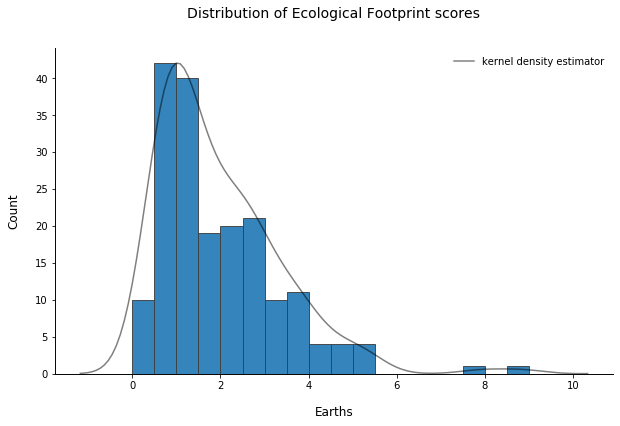

In [12]:
# Create histogram function
def hist_align_bins(variable, xlabel, title, bin_width):
    """
    Create a histogram with bins of a selected width and overlaid with a
    kernel density estimator.
    
    A list of bins for the histogram 'bins' argument is created based on 
    the range of the variable scores and on the selected width of bins.
    The bins are automatically aligned with round units making the
    histogram more readable.
    
    Parameters
    ----------
    variable: pandas Series, numpy 1d-array, or list
        List of values to plot in histogram.
    xlabel: str
        Label x axis.
    title: str
        Figure title.
    bin_width: integer, float
        Width of histogram bins in the units of the variable.
    """
    
    # Create list of bins based on the range of values of the variable
    if np.log10(max(variable)-min(variable)) <= 1:
        start = 0
        stop = 10**ceil(np.log10(max(variable)))
    else:
        rounding_factor = 10**floor(np.log10(max(variable)-min(variable)))
        start = floor(min(variable)/rounding_factor)*rounding_factor
        stop = ceil(max(variable)/rounding_factor)*rounding_factor + bin_width

    bins_range = np.arange(start, stop, bin_width)
    bins_list = bins_range[(bins_range >= min(variable)-2*bin_width) &\
                           (bins_range <= max(variable)+2*bin_width)]
    
    # Draw seaborn histogram
    ax_hist = sns.distplot(variable, bins=bins_list, kde=False,
                           hist_kws={'alpha': 0.9,
                                     'edgecolor': (0.25, 0.25, 0.25),
                                     'linewidth': 1})
    
    # Draw seaborn kde plot on top of histogram with new ax to preserve
    # histogram y axis scale
    # Note: code to be updated once anaconda updates seaborn package to
    # v0.11 where histplot function simplifies this issue
    ax_kde = ax_hist.twinx()
    sns.kdeplot(variable, ax=ax_kde, color='black', alpha=0.5,
                linewidth=1.5, label='kernel density estimator')
    ax_kde.set_yticks([])
    
    # Additional formatting
    ax_hist.set_xlabel(xlabel, size=12, labelpad=15)
    ax_hist.set_ylabel('Count', size=12, labelpad=15)
    plt.title(title, size=14, pad=30)
    plt.legend(frameon=False)
    sns.despine()

# Draw Earths histogram
hist_align_bins(variable=df_ef2016_pivot['Earths'],
                xlabel='Earths',
                title='Distribution of Ecological Footprint scores',
                bin_width=0.5)

In [13]:
# Earths top 10 countries
df_ef2016_pivot.nlargest(10, 'Earths')

,country,code,Earths,HDI,population
137,Qatar,QA,8.84,0.86,2.57e+06
101,Luxembourg,LU,7.92,0.90,5.76e+05
177,United Arab Emirates,AE,5.47,0.86,9.27e+06
12,Bahrain,BH,5.30,0.85,1.43e+06
92,Kuwait,KW,5.27,0.80,4.05e+06
171,Trinidad and Tobago,TT,5.14,0.79,1.36e+06
179,United States,US,4.97,0.92,3.22e+08
32,Canada,CA,4.75,0.92,3.63e+07
113,Mongolia,MN,4.71,0.74,3.03e+06
19,Bermuda,BM,4.61,NaN,6.17e+04


The list contains mainly fossil fuel producing countries with the exceptions of Luxembourg and Bermuda. As a wealthy country, Luxembourg has a high per capita consumption level and it also experiences a [high level of tank tourism](https://web.archive.org/web/20200204044407/https://today.rtl.lu/news/luxembourg/a/1412471.html). Bermuda also is a wealthy country with a high per capita consumption level and it additionaly relies heavily on fossil fuels for all its [energy needs](https://www.worlddata.info/america/bermuda/energy-consumption.php).

In [14]:
# Earths bottom 10 countries
df_ef2016_pivot.nsmallest(10, 'Earths')

,country,code,Earths,HDI,population
168,Timor-Leste,TL,0.30,0.63,1.27e+06
57,Eritrea,ER,0.31,0.44,4.95e+06
28,Burundi,BI,0.40,0.42,1.05e+07
184,Yemen,YE,0.41,0.46,2.76e+07
77,Haiti,HT,0.41,0.50,1.08e+07
41,Congo DR,CD,0.43,0.45,7.87e+07
0,Afghanistan,AF,0.45,0.49,3.47e+07
104,Malawi,MW,0.45,0.47,1.81e+07
141,Rwanda,RW,0.47,0.52,1.19e+07
117,Mozambique,MZ,0.50,0.44,2.88e+07


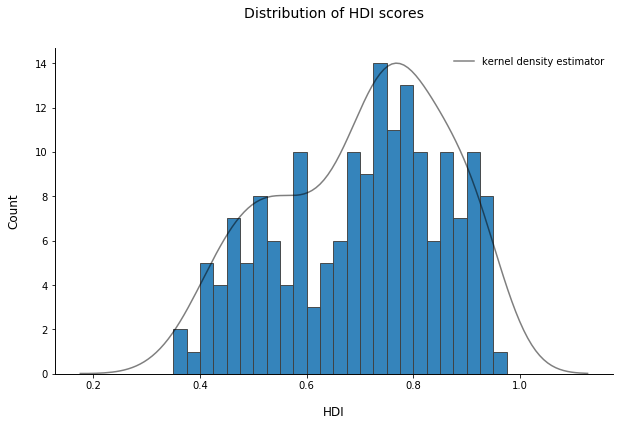

In [15]:
# Draw HDI histogram
hist_align_bins(variable=df_ef2016_pivot['HDI'],
                xlabel='HDI',
                title='Distribution of HDI scores',
                bin_width=0.025)

In [16]:
# HDI top 10
df_ef2016_pivot.nlargest(10, 'HDI')

,country,code,Earths,HDI,population
127,Norway,NO,3.38,0.95,5.25e+06
163,Switzerland,CH,2.85,0.94,8.40e+06
8,Australia,AU,4.07,0.94,2.41e+07
68,Germany,DE,2.97,0.93,8.19e+07
84,Ireland,IE,3.14,0.93,4.73e+06
162,Sweden,SE,3.96,0.93,9.84e+06
148,Singapore,SG,3.61,0.93,5.62e+06
49,Denmark,DK,4.18,0.93,5.71e+06
121,Netherlands,NL,2.97,0.93,1.70e+07
32,Canada,CA,4.75,0.92,3.63e+07


In [17]:
# HDI bottom 10
df_ef2016_pivot.nsmallest(10, 'HDI')

,country,code,Earths,HDI,population
124,Niger,NE,1.02,0.35,2.07e+07
34,Central African Republic,CF,0.75,0.36,4.59e+06
155,South Sudan,SS,0.89,0.39,1.22e+07
35,Chad,TD,0.93,0.41,1.45e+07
147,Sierra Leone,SL,0.73,0.41,7.40e+06
28,Burundi,BI,0.40,0.42,1.05e+07
27,Burkina Faso,BF,0.74,0.42,1.86e+07
106,Mali,ML,0.97,0.42,1.80e+07
98,Liberia,LR,0.68,0.43,4.61e+06
117,Mozambique,MZ,0.50,0.44,2.88e+07


To get a better understanding of how much of the world is covered in the dataset, we can compare the countries listed in the dataset to a comprehensive list of countries considered to be independent States.

## Import list of independent States by scraping online HTML table

A list of independent States will be used as reference to better understand the coverage of the available data, with the assumption that countries or territories that are not independent are small in size and therefore have less impact on the global consumption of resources.
  
The list of [Independent States in the World](https://www.state.gov/independent-states-in-the-world/) published by the United States Department of State (USDS) will be used as reference. It includes GENC country codes which are based on the ISO 3166 country code standard and will be used to merge with the other dataset. This data is in the [public domain](https://www.state.gov/copyright-information/) and may be copied and distributed without permission.
  
The USDS [allows scraping of its website](https://www.state.gov/robots.txt) but for some reason the pandas function *pd.read_html(url)* does not work on this page so the BeautifulSoup package is used here instead.

In [18]:
# Check that webpage access is successful
url = 'https://www.state.gov/independent-states-in-the-world/'
response = requests.get(url)
response.status_code

200

In [19]:
# Scrape table, code based on pluralsight.com/guides/extracting-data-html-beautifulsoup
# and kite.com/python/examples/4420/beautifulsoup-parse-an-html-table-and-write-to-a-csv

html_content = requests.get(url).text
soup = BeautifulSoup(html_content, 'lxml')
table = soup.find('table')

output_rows = []
for table_row in table.findAll('tr'):
    columns = table_row.findAll('td')
    output_row = []
    for column in columns:
        output_row.append(column.text)
    output_rows.append(output_row)

df_USDS_raw = pd.DataFrame(data=output_rows[1:], columns=output_rows[0])
df_USDS_raw

,Short-form name,Long-form name,GENC 2A Code (see Note 2),GENC 3A Code (see Note 2),Capital
0,Afghanistan *+,Islamic Republic of Afghanistan,AF,AFG,Kabul
1,Albania *+,Republic of Albania,AL,ALB,Tirana
2,Algeria *+,People’s Democratic Republic of Algeria,DZ,DZA,Algiers
3,Andorra *+,Principality of Andorra,AD,AND,Andorra la Vella
4,Angola *+,Republic of Angola,AO,AGO,Luanda
...,...,...,...,...,...
190,Venezuela *+,Bolivarian Republic of Venezuela,VE,VEN,Caracas
191,Vietnam *+,Socialist Republic of Vietnam,VN,VNM,Hanoi
192,Yemen *+,Republic of Yemen,YE,YEM,Sanaa
193,Zambia *+,Republic of Zambia,ZM,ZMB,Lusaka


There are 195 independent States according to the USDS.

In [20]:
df_USDS = df_USDS_raw[['Short-form name', 'GENC 2A Code (see Note 2)']].copy()
df_USDS.columns = ['country_USDS', 'code']
df_USDS[30:60]

,country_USDS,code
30,Cambodia *+,KH
31,Cameroon *+,CM
32,Canada *+,CA
33,Central\nAfrican Republic *+,CF
34,Chad *+,TD
35,Chile *+,CL
36,China *+ (see note 3),CN
37,Colombia *+,CO
38,Comoros *+,KM
39,Congo (Brazzaville) *+\n(see note 4),CG


This sample of the table shows that country names contain extra characters and notes which can be removed for better readability.

In [21]:
# Remove extra characters and notes from country names

# Remove '(see note [digit])'
for name in df_USDS.loc[:,'country_USDS']:
    if re.findall(r'[0-9]', name):
        df_USDS.loc[:,'country_USDS'][df_USDS.loc[:,'country_USDS'] == name] = name[:-13]

# Remove '\n' '*+' white spaces and no-break space left of Eswatini
df_USDS.loc[:,'country_USDS'] = df_USDS.loc[:,'country_USDS']\
                                       .str.replace('\n','')\
                                       .str.lstrip('\xa0')\
                                       .str.rstrip(' *+')

# Remove no-break space left of Eswatini country code
df_USDS.loc[:,'code'] = df_USDS.loc[:,'code'].str.lstrip('\xa0 ')

# Print subset of column to check that strings have been formatted correctly
df_USDS[30:60]

,country_USDS,code
30,Cambodia,KH
31,Cameroon,CM
32,Canada,CA
33,CentralAfrican Republic,CF
34,Chad,TD
35,Chile,CL
36,China,CN
37,Colombia,CO
38,Comoros,KM
39,Congo (Brazzaville),CG


In [22]:
# Merge list of independent States with list of countries in EF dataset for comparison
df_ef2016_merge_outer = pd.merge(df_USDS, df_ef2016_pivot[['country', 'code']], how='outer', on='code')
df_ef2016_merge_outer

,country_USDS,code,country
0,Afghanistan,AF,Afghanistan
1,Albania,AL,Albania
2,Algeria,DZ,Algeria
3,Andorra,AD,NaN
4,Angola,AO,Angola
...,...,...,...
200,NaN,PF,French Polynesia
201,NaN,GP,Guadeloupe
202,NaN,MQ,Martinique
203,NaN,MS,Montserrat


In [23]:
# Check that merge is successful
df_ef2016_merge_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_USDS  195 non-null    object
 1   code          205 non-null    object
 2   country       187 non-null    object
dtypes: object(3)
memory usage: 6.4+ KB


The following cell displays the independent States not included in the EF dataset.

In [24]:
missing_states = df_ef2016_merge_outer[df_ef2016_merge_outer['country'].isna()]
print(missing_states)
print()
print(f'Number of independent countries not included in EF dataset:\
 {len(missing_states)}')

                         country_USDS code country
3                             Andorra   AD     NaN
74                           Holy See   VA     NaN
77                            Iceland   IS     NaN
90                           Kiribati   KI     NaN
93                             Kosovo   XK     NaN
102                     Liechtenstein   LI     NaN
108                          Maldives   MV     NaN
111                  Marshall Islands   MH     NaN
115    Micronesia,Federated States of   FM     NaN
117                            Monaco   MC     NaN
123                             Nauru   NR     NaN
134                             Palau   PW     NaN
146             Saint Kitts and Nevis   KN     NaN
148  Saint Vincent and the Grenadines   VC     NaN
150                        San Marino   SM     NaN
155                        Seychelles   SC     NaN
181                            Tuvalu   TV     NaN
189                           Vanuatu   VU     NaN

Number of independent countrie

It is also interesting to see which are the 10 out of the 187 countries listed in the EF dataset that are not independent.

In [25]:
additional_territories = df_ef2016_merge_outer[df_ef2016_merge_outer['country_USDS'].isna()]
print(additional_territories)
print()
print(f'Number of dependent territories included in EF dataset:\
 {len(additional_territories)}')

    country_USDS code           country
195          NaN   AW             Aruba
196          NaN   BM           Bermuda
197          NaN   KY    Cayman Islands
198          NaN   CK      Cook Islands
199          NaN   GF     French Guiana
200          NaN   PF  French Polynesia
201          NaN   GP        Guadeloupe
202          NaN   MQ        Martinique
203          NaN   MS        Montserrat
204          NaN   RE           Reunion

Number of dependent territories included in EF dataset: 10


10 dependent territories are included in the EF dataset with a computed ecological footprint. As they are not independent states they have not been included in the HDI, along with North Korea and Somalia, as shown in the table below.

In [26]:
# Display EF dataset countries/territories with no HDI
df_ef2016_pivot[df_ef2016_pivot['HDI'].isna()]

,country,code,Earths,HDI,population
7,Aruba,AW,4.00,NaN,1.05e+05
19,Bermuda,BM,4.61,NaN,6.17e+04
33,Cayman Islands,KY,3.56,NaN,6.08e+04
42,Cook Islands,CK,3.11,NaN,1.74e+04
63,French Guiana,GF,1.46,NaN,2.76e+05
64,French Polynesia,PF,2.48,NaN,2.80e+05
72,Guadeloupe,GP,2.53,NaN,4.50e+05
108,Martinique,MQ,2.72,NaN,3.85e+05
115,Montserrat,MS,2.76,NaN,5.15e+03
126,North Korea,KP,0.55,NaN,2.54e+07


Now that we better understand the coverage of the dataset, it would be interesting to include information about the region to which each country belongs as it would provide a better overview of the geographical distribution of the scores of both indicators.

## Import list of countries with regions from GitHub repository

This information can be obtained from different places. A list built by [GitHub user *lukes*](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes) last updated on 19 March 2019 will be imported here. This list has been obtained by merging two sources, the [Wikipedia ISO 3166-1 article](https://en.wikipedia.org/wiki/ISO_3166-1#Officially_assigned_code_elements) table containing the alpha and numeric country codes, and the [United Nations Statistics Division table](https://unstats.un.org/unsd/methodology/m49/overview) containing regional, and sub-regional names and codes. The information on regions may also be obtained by downloading a CSV or Excel file from the [United Nations Statistics Division page](https://unstats.un.org/unsd/methodology/m49/overview).

In [27]:
# Note: set keep_default_na to False to avoid Namibia code NA from being
# interpreted as NaN when merging dataframes later on
url = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
df_regions_raw = pd.read_csv(url, keep_default_na=False)
df_regions_raw

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,,142,034,
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,,150,154,
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,,150,039,
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,,002,015,
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,,009,061,
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,,009,061,
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,,002,015,
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,,142,145,
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014


In [28]:
df_regions = df_regions_raw[['alpha-2', 'region']]
df_regions.columns = ['code', 'continent']
df_regions

,code,continent
0,AF,Asia
1,AX,Europe
2,AL,Europe
3,DZ,Africa
4,AS,Oceania
...,...,...
244,WF,Oceania
245,EH,Africa
246,YE,Asia
247,ZM,Africa


In [29]:
# Merge df_ef2016_pivot with df_regions to get continents for all
# countries and territories
df_ef2016 = pd.merge(df_ef2016_pivot, df_regions, how='left', on='code')
df_ef2016

,country,code,Earths,HDI,population,continent
0,Afghanistan,AF,0.45,0.49,3.47e+07,Asia
1,Albania,AL,1.23,0.78,2.93e+06,Europe
2,Algeria,DZ,1.48,0.75,4.06e+07,Africa
3,Angola,AO,0.62,0.58,2.88e+07,Africa
4,Antigua and Barbuda,AG,2.66,0.78,1.01e+05,Americas
...,...,...,...,...,...,...
182,Venezuela,VE,1.56,0.77,3.16e+07,Americas
183,Viet Nam,VN,1.30,0.69,9.46e+07,Asia
184,Yemen,YE,0.41,0.46,2.76e+07,Asia
185,Zambia,ZM,0.58,0.59,1.66e+07,Africa


In [30]:
# Check that merge is successful
df_ef2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     187 non-null    object 
 1   code        187 non-null    object 
 2   Earths      187 non-null    float64
 3   HDI         175 non-null    float64
 4   population  187 non-null    float64
 5   continent   187 non-null    object 
dtypes: float64(3), object(3)
memory usage: 10.2+ KB


The merging appears to be successful as all countries and territories have an attributed continent.

# Data analysis

Now that the dataset is ready for further analysis, it is time to look at the distribution of the country scores for the EF and HDI grouped by continent and to visualize the relationship between these two variables.

## Ecological Footprint by continent

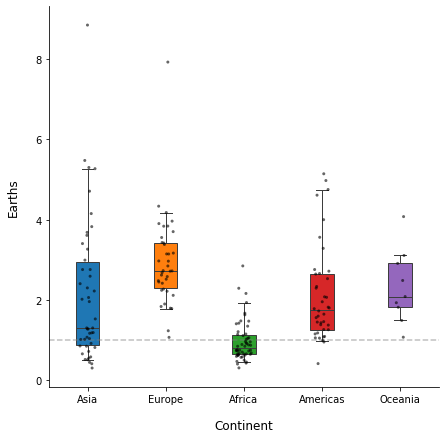

In [31]:
data=df_ef2016
var_cat='continent'
var_num='Earths'

# Draw boxplots overlaid with stripplots of EF scores grouped by continent
# Note: the boxplots are drawn with whiskers that reach out to farthest
# data point within the interval contained by the 5th and 95th percentiles
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(data=data, x=var_cat, y=var_num, whis=(5, 95), linewidth=1,
            width=0.3, fliersize=False, saturation=1)
sns.stripplot(data=data, x=var_cat, y=var_num, color="k", alpha=0.6, size=3)

# Add horizontal line for one planet limit and additional formatting
ax.axhline(1, color='grey', ls='dashed', alpha=0.5)
ax.set_xlabel('Continent', size=12, labelpad=15)
ax.set_ylabel('Earths', size=12, labelpad=15)
sns.despine();

The dashed line represents the one planet limit. The boxplots are drawn with whiskers that reach out to farthest data point within the interval contained by the 5th and 95th percentiles. Countries from both Europe and Oceania are all consuming in excess of Earth's resources, as well as nearly all of North and South American countries with a few exceptions:

In [32]:
df_ef2016[(df_ef2016['Earths']<=1) & (df_ef2016['continent']=='Americas')]

,country,code,Earths,HDI,population,continent
77,Haiti,HT,0.41,0.50,1.08e+07,Americas
78,Honduras,HN,0.95,0.61,9.11e+06,Americas
87,Jamaica,JM,0.99,0.73,2.88e+06,Americas


Many Asian and African countries appear to be within the planet's limits. These can be identified in the scatterplot further below.

African countries are very frugal in their consumption, very few exceed the 2 Earths mark:

In [33]:
df_ef2016[(df_ef2016['Earths']>=2) & (df_ef2016['continent']=='Africa')]

,country,code,Earths,HDI,population,continent
99,Libya,LY,2.29,0.69,6.29e+06,Africa
110,Mauritius,MU,2.16,0.79,1.26e+06,Africa
138,Reunion,RE,2.85,NaN,8.70e+05,Africa


Asian countries on the other hand show a very wide distribution in resource consumption. Their EF ranges from 0.3 Earth equivalents up to 8.8 with a median of 1.3:

In [34]:
df_ef2016[df_ef2016['continent']=='Asia']['Earths'].describe()

count    46.00
mean      2.13
std       1.76
min       0.30
25%       0.87
50%       1.30
75%       2.93
max       8.84
Name: Earths, dtype: float64

## Human Development Index by continent

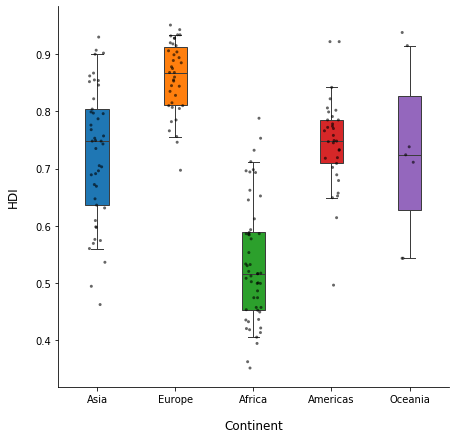

In [35]:
data=df_ef2016.dropna(axis=0, how='any') # Drop rows with NaN (present only in HDI column)
var_cat='continent'
var_num='HDI'

# Draw boxplots overlaid with stripplots of HDI scores grouped by continent
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(data=data, x=var_cat, y=var_num, whis=(5, 95), linewidth=1,
            width=0.3, fliersize=False, saturation=1)
sns.stripplot(data=data, x=var_cat, y=var_num, color="k", alpha=0.6, size=3)

# Additional formatting
ax.set_xlabel('Continent', size=12, labelpad=15)
ax.set_ylabel('HDI', size=12, labelpad=15)
sns.despine();

The HDI scores are widely spread within each continent and a few countries stand out as high-performers while some others lag behind the rest. These outliers are the following:

In [36]:
# HDI scores bottom 5% of each continent
df_ef2016.groupby('continent')\
         .apply(lambda df: df[df['HDI'] <= df['HDI'].quantile(0.05)])

country code  Earths   HDI  population  \
continent                                                                
Africa    34   Central African Republic   CF    0.75  0.36    4.59e+06   
          124                     Niger   NE    1.02  0.35    2.07e+07   
          155               South Sudan   SS    0.89  0.39    1.22e+07   
Americas  77                      Haiti   HT    0.41  0.50    1.08e+07   
          78                   Honduras   HN    0.95  0.61    9.11e+06   
Asia      0                 Afghanistan   AF    0.45  0.49    3.47e+07   
          164                     Syria   SY    0.85  0.54    1.84e+07   
          184                     Yemen   YE    0.41  0.46    2.76e+07   
Europe    112                   Moldova   MD    1.07  0.70    4.06e+06   
          176                   Ukraine   UA    1.78  0.75    4.44e+07   
Oceania   131          Papua New Guinea   PG    1.07  0.54    8.08e+06   
          151           Solomon Islands   SB    1.49  0.54    5.99e+05   

              continent  
continent                
Africa    34     Africa  
          124    Africa  
          155    Africa  
Americas  77   Americas  
          78   Americas  
Asia      0        Asia  
          164      Asia  
          184      Asia  
Europe    112    Europe  
          176    Europe  
Oceania   131   Oceania  
          151   Oceania

In [37]:
# HDI scores top 5% of each continent
df_ef2016.groupby('continent')\
         .apply(lambda df: df[df['HDI'] >= df['HDI'].quantile(0.95)])

country code  Earths   HDI  population continent
continent                                                            
Africa    2          Algeria   DZ    1.48  0.75    4.06e+07    Africa
          110      Mauritius   MU    2.16  0.79    1.26e+06    Africa
          172        Tunisia   TN    1.35  0.73    1.14e+07    Africa
Americas  32          Canada   CA    4.75  0.92    3.63e+07  Americas
          179  United States   US    4.97  0.92    3.22e+08  Americas
Asia      85          Israel   IL    2.99  0.90    8.19e+06      Asia
          88           Japan   JP    2.76  0.91    1.28e+08      Asia
          148      Singapore   SG    3.61  0.93    5.62e+06      Asia
Europe    127         Norway   NO    3.38  0.95    5.25e+06    Europe
          163    Switzerland   CH    2.85  0.94    8.40e+06    Europe
Oceania   8        Australia   AU    4.07  0.94    2.41e+07   Oceania

## Ecological Footprint vs Human Development Index

In [38]:
# Draw interactive scatterplot of EF vs HDI using Altair library

base = alt.Chart(df_ef2016)

# Draw circles
circle = base.mark_circle(clip=True).encode(
    x=alt.X('HDI', title='Human Development Index 2016'),
    y=alt.Y('Earths', title='Ecological Footprint (Earths equivalent)'),
    color='continent',
    tooltip=['country',
             alt.Tooltip('HDI:Q', format='.2f'),
             alt.Tooltip('Earths:Q', format='.2f'),
             alt.Tooltip('population:Q', format=',')]
).properties(
    width=600,
    height=400
).interactive()

# Draw horizontal dashed line
Earth_limit = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(
    color="#808080",
    strokeDash=[4,4]
).encode(
    y='y')

# Draw vertical dashed line
HDI_median = base.mark_rule(
    color="#808080",
    strokeDash=[4,4]
).encode(
    x='median(HDI)'
)

circle + Earth_limit + HDI_median

alt.LayerChart(...)

The horizontal dashed line marks the one planet limit. The vertical dashed line marks the median HDI. Nearly all countries consuming resources within Earth's total biocapacity score low on the HDI. The only exception is Sri Lanka which has an HDI score of 0.77 while maintaining consumption at a sustainable level. It is followed by Jamaica with an HDI score of 0.73 just below the median HDI. All other countries in the the top half of HDI scores are consuming resources at an unsustainable level.

The duty of policy-makers and other development stakeholders is to shift countries to the bottom-right quadrant. This means that those in high-consumption countries must put in place policies to decrease resource use, while those in low-consumption countries must find alternative ways to increase health, education and standard of living, as they cannot follow the development path of high-consumption countries.

In facing these challenges, it can be interesting to look more closely at which countries are the most efficient in resource consumption relative to their HDI score. Knowing which countries are most resource-efficient per HDI point may bring to light successful policies that may serve as examples for others. The development efficiency indicator is computed in the next section to identify those countries.

## Development efficiency

In [39]:
df_ef2016['development_efficiency'] = df_ef2016['HDI']/df_ef2016['Earths']
df_ef2016['development_efficiency'].describe()

count    175.00
mean       0.51
std        0.28
min        0.10
25%        0.33
50%        0.44
75%        0.65
max        2.07
Name: development_efficiency, dtype: float64

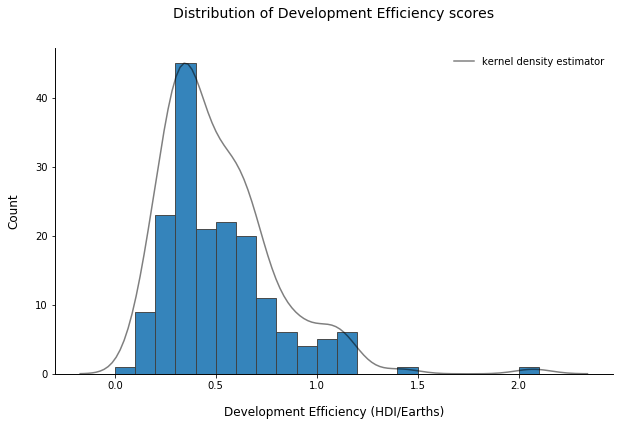

In [40]:
# Draw development efficiency histogram
hist_align_bins(variable=df_ef2016['development_efficiency'],
                xlabel='Development Efficiency (HDI/Earths)',
                title='Distribution of Development Efficiency scores',
                bin_width=0.1)

In [41]:
# Development efficienty top 10
df_ef2016.nlargest(10, 'development_efficiency')

,country,code,Earths,HDI,population,continent,development_efficiency
168,Timor-Leste,TL,0.30,0.63,1.27e+06,Asia,2.07
57,Eritrea,ER,0.31,0.44,4.95e+06,Africa,1.42
77,Haiti,HT,0.41,0.50,1.08e+07,Americas,1.20
13,Bangladesh,BD,0.52,0.60,1.63e+08,Asia,1.16
184,Yemen,YE,0.41,0.46,2.76e+07,Asia,1.12
165,Tajikistan,TJ,0.58,0.65,8.73e+06,Asia,1.11
141,Rwanda,RW,0.47,0.52,1.19e+07,Africa,1.11
0,Afghanistan,AF,0.45,0.49,3.47e+07,Asia,1.11
129,Pakistan,PK,0.51,0.56,1.93e+08,Asia,1.09
41,Congo DR,CD,0.43,0.45,7.87e+07,Africa,1.06


Among the top 10 countries in terms of development efficiency, none are even close to the median HDI, only Timor-Leste and Tajikistan make it above the 0.6 mark. To get a list of potential standard-setters, we can further refine the list by setting a minimum HDI.

In [42]:
# Select top 10 countries with near and above median HDI
df_ef2016[df_ef2016['HDI'] >= 0.7].nlargest(10, 'development_efficiency')

,country,code,Earths,HDI,population,continent,development_efficiency
157,Sri Lanka,LK,0.92,0.77,2.08e+07,Asia,0.84
87,Jamaica,JM,0.99,0.73,2.88e+06,Americas,0.74
53,Ecuador,EC,1.05,0.75,1.64e+07,Americas,0.71
46,Cuba,CU,1.09,0.77,1.15e+07,Americas,0.71
52,Dominican Republic,DO,1.06,0.73,1.06e+07,Americas,0.69
180,Uruguay,UY,1.18,0.80,3.44e+06,Americas,0.68
1,Albania,AL,1.23,0.78,2.93e+06,Europe,0.63
6,Armenia,AM,1.19,0.75,2.92e+06,Asia,0.63
67,Georgia,GE,1.30,0.78,3.93e+06,Asia,0.60
181,Uzbekistan,UZ,1.18,0.70,3.14e+07,Asia,0.60


As observed in the scatterplot, only Sri Lanka and Jamaica are within the one planet limit, with a near-median HDI. Uruguay stands out as the only country reaching the 0.8 HDI mark. Albania makes it in the list as the only European country and, along with the last three countries in the list, it is considered as an economy in transition by the United Nations country classification in the [World Economic Situation and Prospects report from 2019](https://www.un.org/development/desa/dpad/wp-content/uploads/sites/45/WESP2019_BOOK-ANNEX-en.pdf). The other 6 countries are considered to be developing economies.

Each of these countries would have to be studied further to better understand how they score so high on the HDI in such a resource-efficient manner. Some of them may have policies in place that could serve as examples of good practice for other countries facing similar challenges.

Finally, we can have a look at what countries are the least resource efficient relative to the HDI:

In [43]:
# Development efficiency bottom 10
df_ef2016.nsmallest(10, 'development_efficiency')

,country,code,Earths,HDI,population,continent,development_efficiency
137,Qatar,QA,8.84,0.86,2.57e+06,Asia,0.10
101,Luxembourg,LU,7.92,0.90,5.76e+05,Europe,0.11
92,Kuwait,KW,5.27,0.80,4.05e+06,Asia,0.15
171,Trinidad and Tobago,TT,5.14,0.79,1.36e+06,Americas,0.15
177,United Arab Emirates,AE,5.47,0.86,9.27e+06,Asia,0.16
113,Mongolia,MN,4.71,0.74,3.03e+06,Asia,0.16
12,Bahrain,BH,5.30,0.85,1.43e+06,Asia,0.16
179,United States,US,4.97,0.92,3.22e+08,Americas,0.19
32,Canada,CA,4.75,0.92,3.63e+07,Americas,0.19
128,Oman,OM,4.15,0.82,4.42e+06,Asia,0.20


These are mainly fossil fuel producing countries with the exception of Luxembourg. These countries would have to be investigated further to better understand why they make it into this list.

# Conclusion

This analysis has shed some light on the situation of countries regarding their ecological footprint and their level of development. Sri Lanka stands out as being the only country with a sustainable level resource consumption while achieving an above-median score on the HDI. None of the countries among what are considered as developed economies according to the United Nations are even close to the one planet limit, most are well above the 2 Earths mark, with the exception of Romania.

This goes to show that all countries still have a lot of work to do in order to achieve a sustainable level of development on both social and environmental issues. As the UN Sustainable Development Goals are becoming the new benchmark for assessing the level of development of countries, one could question the use of the classification 'developed', 'in transition', and 'developing', as the scores on the ecological footprint clearly show that the so-called developed countries still have a way to go in order to achieve a sustainable level of consumption while maintaining a high standard of living.